# MODULES IMPORT

In [3]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #pandas used for data manipulation and analysis.
                 
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path

import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors

----------------
## MAML

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, Optimizer
from pathlib import Path
from os.path import join
from collections import OrderedDict
import torch
import torch.nn.functional as F

In [5]:
def load_data(path):
    tasks = []
    for file_path in os.listdir(path):
        task_file = join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [6]:
path = Path("./data")
train_tasks = load_data(path / 'training')
evaluation_tasks = load_data(path /'evaluation')
test_tasks = load_data(path / 'test')

In [7]:
def max_padding(x):
    x = torch.Tensor(x)
    return nn.ConstantPad2d((floor((30 - x.shape[1])/2), floor((30 - x.shape[2])/2),
                                       ceil((30 - x.shape[2])/2), ceil((30 - x.shape[1])/2)), 0)(x)
    

In [8]:
class ArcData(Dataset):

    def __init__(self, Xy, type_ = "train"):
        
        self.Xy = Xy
        self.type = type_
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        Xy = self.Xy[idx][self.type]
        X = [x["input"] for x in Xy]
        
        if self.type == "train" or self.type == "test":
            y = [y["output"] for y in Xy]
            return np.array(X), np.array(y)
        else:
            return np.array(X)
    


In [10]:
def expand(x):
    x = np.array(x)
    if len(x.shape) != 2:
        x = np.expand_dims(x, 1)
    return x

def pad(x):
    img = np.array([np.zeros((x.shape[0], x.shape[1]))+i for i in range(10)])
    img = (x-img == 0)*1
    return img

# def calk_score(predict, y):
#     return [int(np.equal(y, predict).all())]

def check_list(x):
    types = [type(i) for arr in x for i in arr]
    if any([types == [type(list()) for _ in range(len(types))]]):
        x = np.array([np.array([el for el in i]) for i in x]).squeeze()
    return x

def shapes(x):
    s = []
    if str(x).isdigit() == False:
        for arr in x:
            s.append(arr.shape)
    else:
        s.append(1)
    return s
def input_output_shape_is_same(batch):
    return all([np.array(el["input"]).shape == np.array(el["output"]).shape for el in batch["train"]])
def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [560]:
def replace_grad(parameter_gradients, parameter_name):
    """Creates a backward hook function that replaces the calculated gradient
    with a precomputed value when .backward() is called.
    
    See
    https://pytorch.org/docs/stable/autograd.html?highlight=hook#torch.Tensor.register_hook
    for more info
    """
    def replace_grad_(module):
        return parameter_gradients[parameter_name]

    return replace_grad_

class DummyModel(torch.nn.Module):
    """Dummy 1 layer (0 hidden layer) model for testing purposes"""
    def __init__(self, k: int):
        super(DummyModel, self).__init__()
        self.out = nn.Conv2d(10, k,kernel_size = 5, padding = 2, bias=False)

    def forward(self, x):
        x = self.out(x)
        return x

    def functional_forward(self, x, weights):
        x = F.conv2d(x, weights['out.weight'], padding = 2)
        return x
    
def create_nshot_task_label(k: int, q: int, shape: int) -> torch.Tensor:
    """Creates an n-shot task label.
    Label has the structure:
        [0]*q + [1]*q + ... + [k-1]*q
    # TODO: Test this
    # Arguments
        k: Number of classes in the n-shot classification task
        q: Number of query samples for each class in the n-shot classification task
    # Returns
        y: Label vector for n-shot task of shape [q * k, ]
    """
    y = torch.stack([torch.arange(0, shape, 1 / q).long()]).long()
    return y

NUM_EPOCHS = 30

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")

training_set = ArcData(train_tasks, "train")
history = []

result = []
predictions = []

model = DummyModel(10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.1)
data_shape = tuple((6,))
inner_train_steps = 30
order = 2
train = True
n_shot = 1
inner_lr = 0.1
create_graph = (True if order == 2 else False) and train


task_predictions = []
inputs, outputs = [] , []
for batch in train_tasks:
    if input_output_shape_is_same(batch):
        batches_inp = []
        batches_outp = []
        for sample in batch["train"]:
            batches_inp.append(torch.Tensor(pad(np.array(sample["input"]))))
            batches_outp.append(torch.LongTensor(np.array(sample["output"])))
        inputs.append(batches_inp)
        outputs.append(batches_outp)
 

for epoch in tqdm(range(NUM_EPOCHS)):
    task_gradients = []
    task_losses = []
    for meta_batch_samples, meta_batch_labels in zip(inputs, outputs):
        # By construction x is a 5D tensor of shape: (meta_batch_size, n*k + q*k, channels, width, height)
        # Hence when we iterate over the first  dimension we are iterating through the meta batches
        # Equivalently y is a 2D tensor of shape: (meta_batch_size, n*k + q*k, 1)
        x_task_train = meta_batch_samples[:-2]
        x_task_val = meta_batch_samples[-2:]
        y_task_train = meta_batch_labels[:-2]
        y_task_val = meta_batch_labels[-2:]
        # Create a fast model using the current meta model weights
        fast_weights = OrderedDict(model.named_parameters())


        # Train the model for `inner_train_steps` iterations
        for inner_batch in range(inner_train_steps):
            for x,y in zip(x_task_train, y_task_train):
            # Perform update of model weights
                logits = model.functional_forward(torch.Tensor(x).unsqueeze(0).to(device), fast_weights)
                loss = loss_fn(logits.to(device), y.unsqueeze(0).to(device))
                gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)
                # Update weights manually
                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), gradients)
                )

        # Do a pass of the model on the validation data from the current task
        logits = []
        losses = []
        for x,y in zip(x_task_val, y_task_val):
            lgt = model.functional_forward(torch.Tensor(x).unsqueeze(0).to(device), fast_weights)
            logits.append(lgt)
            loss = loss_fn(lgt.to(device), y.unsqueeze(0).to(device))
            losses.append(loss)
            loss.backward(retain_graph=True)
        # Get post-update accuracies
        task_predictions.append(logits)

        # Accumulate losses and gradients
        task_losses.append(torch.stack(losses))
        gradients = torch.autograd.grad(losses, fast_weights.values(), create_graph=create_graph)
        named_grads = {name: g for ((name, _), g) in zip(fast_weights.items(), gradients)}
        task_gradients.append(named_grads)

    if order == 1:
        if train:
            sum_task_gradients = {k: torch.stack([grad[k] for grad in task_gradients]).mean(dim=0)
                                  for k in task_gradients[0].keys()}
            hooks = []
            for name, param in model.named_parameters():
                hooks.append(
                    param.register_hook(replace_grad(sum_task_gradients, name))
                )

            model.train()
            optimizer.zero_grad()
            # Dummy pass in order to create `loss` variable
            # Replace dummy gradients with mean task gradients using hooks
            logits = model(torch.zeros((10, 1, ) + data_shape).unsqueeze(0).to(device))
            loss = loss_fn(logits, create_nshot_task_label(1, 1, 6).unsqueeze(0).to(device))
            loss.backward()
            optimizer.step()

            for h in hooks:
                h.remove()


    elif order == 2:
        model.train()
        optimizer.zero_grad()
        meta_batch_loss = torch.stack([i for j in task_losses for i in j]).mean()
        if train:
            meta_batch_loss.backward()
            optimizer.step()



KeyboardInterrupt: 

In [561]:
scores = []
for batch in train_tasks:
    if input_output_shape_is_same(batch):
        pred = []
        for sample in batch["test"]:
            p = model(torch.Tensor(pad(np.array(sample["input"]))).unsqueeze(0).to(device))
            
            pred.append(p)
        predictions = [i.squeeze(0).cpu().detach().numpy().argmax(0) for j in pred for i in j]
        score = calk_score(batch["test"], predictions)
        scores.append(score)

In [562]:
scores

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

--------------------
# basic cnn

In [341]:
from collections import OrderedDict
correct = []
val_set = ArcData(train_tasks, "test")
NUM_EPOCHS = 30

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")
device = "cpu"

training_set = ArcData(train_tasks, "train")
history = []

result = []
predictions = []
for batch in tqdm(train_tasks):
    if input_output_shape_is_same(batch):
        net = DummyModel(10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(net.parameters(), lr = 0.1)
        for epoch in range(NUM_EPOCHS):
            for sample in batch["train"]:
                #print(sample)
                
                x = expand(sample["input"])
                y = expand(sample["output"])

                padded_x = pad(x)

                inputs = torch.Tensor(padded_x).unsqueeze(0).to(device)
                outputs = torch.LongTensor(y).unsqueeze(0).to(device)
#                 meta_gradient_step(net, optimizer, criterion, inputs, outputs, 10, 5, 1, 10, 0.1, True, device)
                optimizer.zero_grad()
                out = net(inputs)
                loss = criterion(out, outputs)
                history.append(loss)
                loss.backward()
                optimizer.step()
        p = []
        with torch.no_grad():
            for sample in batch["test"]:
                x = sample["input"]
                y = sample["output"]
                #print(sample)
                x = expand(x)
                y = expand(y)
    #                 x = check_list(x)
    #                 y = check_list(y)

    #             shapes_x = shapes(x)
    #             shapes_y = shapes(y)

    #             if all([shapes_x == shapes_y]):

                padded_x = pad(x)

                inputs = torch.FloatTensor(padded_x).unsqueeze(0).to(device)

                pred = net(inputs)

                pred = pred.squeeze(dim = 0).cpu().numpy().argmax(0)
                p.append(pred)
        score = calk_score(batch['test'], p)
                
    else:
        pred = [el['input'] for el in batch['test']]
        score = [0]*len(batch['test'])
    predictions.append(pred)
    result.append(score)

print(result)


[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [1], [0, 0], [0], [0], [0, 0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0],

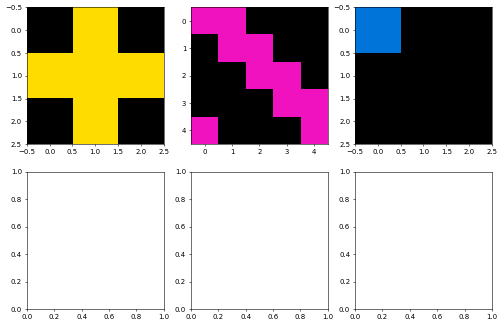

In [295]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

fig, axs = plt.subplots(2, len(correct), figsize=(4*len(correct),8), dpi=50)
for n, i in enumerate(correct):
    axs[0][n].imshow(i, cmap=cmap, norm=norm)
plt.show()

In [318]:
plt.plot([list(i.detach().numpy()) for i in task_losses])

AttributeError: 'list' object has no attribute 'detach'